## Loading Dataset

In [1]:
import pandas as pd

RAW_DATA_PATH = "../data/raw/KSI.csv"

df = pd.read_csv(RAW_DATA_PATH)

## Identify features with less than 5% missing values

In [2]:
features_less_5 = []
for feature in df.columns:
    percent_missing = df[feature].isnull().mean()*100
    if percent_missing < 5 and percent_missing > 0:
        features_less_5.append(feature)
print(features_less_5)

['ROAD_CLASS', 'DISTRICT', 'WARDNUM', 'LOCCOORD', 'TRAFFCTL', 'VISIBILITY', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE']


# Drop the rows with missing values from the previous features

In [3]:
print(f"Initial Shape: {df.shape}")
df.dropna(subset=features_less_5, inplace=True )
print(f"New Shape: {df.shape}")

Initial Shape: (17488, 57)
New Shape: (16447, 57)


## Create a custom transformer to handle missing values of VEHTYPE

In [4]:
from sklearn.base import TransformerMixin, BaseEstimator


class FillMissing(BaseEstimator, TransformerMixin):
    def __init__(self, group_col='ACCNUM', value_col='VEHTYPE'):
        self.group_col = group_col
        self.value_col = value_col
    
    def fit(self, X):
        return self
        
    def transform(self, X):
        # Separate the columns that will be updated
        update_cols = [self.group_col, self.value_col]
        
        # Create a copy of the dataframe to avoid modifying the original
        filled = X.copy()
        
        # Group the data by "ACCNUM" and fill in missing values
        filled[update_cols] = filled.groupby(self.group_col)[update_cols].ffill().bfill()
        filled = filled[update_cols]
        
        return filled

## Fill missing values of VEHTYPE column

In [5]:
print(df['VEHTYPE'].isnull().sum())
filler = FillMissing()
df[['ACCNUM', 'VEHTYPE']] = filler.transform(df)

print(df['VEHTYPE'].isnull().sum())

2782
0


## Yes / No Transformer

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

steps = [('imputer', SimpleImputer(strategy='constant',fill_value='No')),
         ('onehot', OneHotEncoder(drop='first',sparse=False))]

yes_no_pipe = Pipeline(steps)

# Find columns with yes/no values and transform them

In [7]:
categorical_index = df.dtypes[df.dtypes == 'object'].index
categorical = df[categorical_index]
unique_count = categorical.nunique()
binary_indeces = [i for i in categorical_index if df[i].nunique() == 1]
print(binary_indeces)

['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY']


In [8]:
df[binary_indeces] = yes_no_pipe.fit_transform(df[binary_indeces])

## Time transformer

In [9]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np

class TimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def transform(self, X):
        #return [int(row // 100) for row in X]
        return X.apply(lambda row: int((row//100) + 1 if int(str(row)[-2:]) > 30 else row//100))
        #return pd.Dataframe([(row//100) + 1 if int(str(row)[-2:]) > 30 else row//100 for row in X.values])

    def fit(self, X):
        return self
    

## Transform Time column

In [10]:
df['TIME'] = TimeTransformer().transform(df['TIME'])


In [11]:
df['TIME'].value_counts()

18    1173
16    1019
15    1014
19     996
17     984
20     937
13     867
14     824
21     818
22     737
9      730
11     716
12     692
10     676
23     644
7      565
8      506
3      481
1      475
6      415
2      354
0      299
4      223
24     154
5      148
Name: TIME, dtype: int64

## Date transformer

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin 
from datetime import datetime

class DayofWeekMonth(BaseEstimator, TransformerMixin): 
    def __init__(self): 
        #self.result = pd.DataFrame()
        pass 
    
    def fit(self,X): 
        return self 
    
    def transform(self, X): 
        print(type(X))
        date = pd.to_datetime(X.squeeze(), format='%Y/%m/%d')
        #date = X.apply(lambda val: datetime.strptime(val[:10], '%Y/%m/%d'))
        #print(date)
        result = pd.DataFrame()
        result['DAY'] = date.apply(lambda x: int(datetime.weekday(x)))
        result['MONTH'] = date.apply(lambda x: int(x.month))
        return result

## Transform the DATE column into a WEEKDAY and MONTH

In [13]:
df[['DAY', 'MONTH']] = DayofWeekMonth().transform(df['DATE'])[['DAY', 'MONTH']]
df.drop('DATE', axis=1)
df['DAY'].head(5)

<class 'pandas.core.series.Series'>


0    6
1    6
2    6
3    6
4    6
Name: DAY, dtype: int64

## Fatal accidents per month

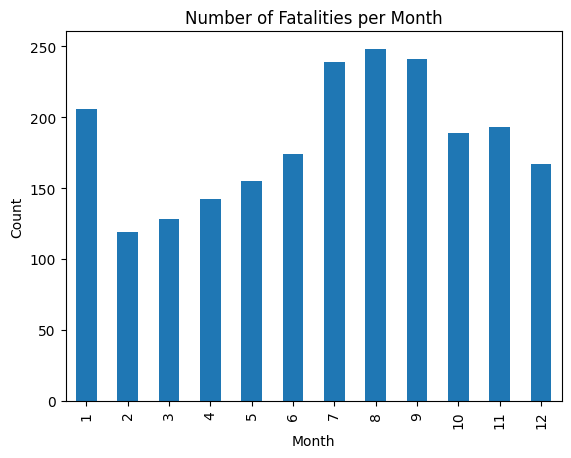

In [14]:
import matplotlib.pyplot as plt
# create a filtered dataframe where the Label is equal to 'fatal'
fatal_df = df[df['ACCLASS'] == 'Fatal']

# plot a histogram of the number of values per hour
fatal_df['MONTH'].value_counts().sort_index(ascending=True).plot(kind='bar', width=0.5)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Number of Fatalities per Month')
plt.xticks(rotation=90)
plt.show()

## Fatal accidents per weekday

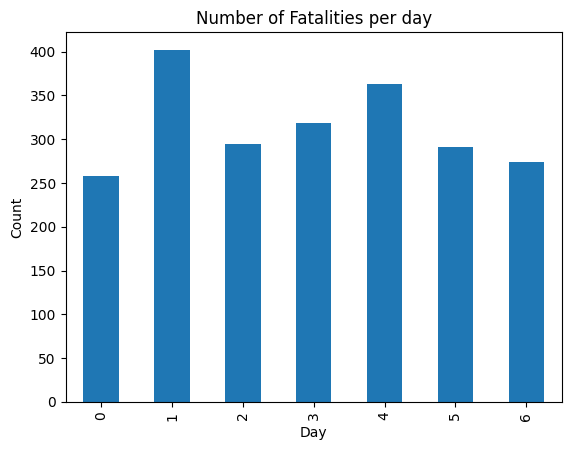

In [15]:
import matplotlib.pyplot as plt
# create a filtered dataframe where the Label is equal to 'fatal'
fatal_df = df[df['ACCLASS'] == 'Fatal']

# plot a histogram of the number of values per hour
fatal_df['DAY'].value_counts().sort_index(ascending=True).plot(kind='bar', width=0.5)
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Number of Fatalities per day')
plt.xticks(rotation=90)
plt.show()

In [16]:
labels = df['ACCLASS']
labels.value_counts()

Non-Fatal Injury        14240
Fatal                    2201
Property Damage Only        6
Name: ACCLASS, dtype: int64

## replace the Property Damage Only with Non-Fatal Injury and One hot encode them

In [17]:
labels = labels.apply(lambda x: 1 if x == 'Fatal' else 0)

In [18]:
labels.value_counts()

0    14246
1     2201
Name: ACCLASS, dtype: int64

In [19]:
labels.isnull().sum()

0

# Define the categorical and numerical features to keep

In [20]:
cat_attribs = ['VEHTYPE', 'ROAD_CLASS', 'LOCCOORD', 'DISTRICT', 'TRAFFCTL', 'LIGHT', 'RDSFCOND', 'VISIBILITY', 'INVTYPE', 'IMPACTYPE', 'INVAGE']
num_attribs = ['YEAR', 'TIME', 'LATITUDE', 'LONGITUDE', 'MONTH', 'DAY']

In [21]:
df[num_attribs].isnull().sum()

YEAR         0
TIME         0
LATITUDE     0
LONGITUDE    0
MONTH        0
DAY          0
dtype: int64

# Pipeline for numerical features

In [22]:
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

transformers = [('scaler', num_pipeline, num_attribs),
                ("cat", OneHotEncoder(drop='first',sparse=False), cat_attribs),
                ("binary", "passthrough", binary_indeces)]
ct = ColumnTransformer(transformers, remainder='drop')

result = ct.fit_transform(df)

In [24]:
#dense_array = result.toarray()
new_df = pd.DataFrame(result)

In [25]:
#add labels to the dataframe
new_df['label'] = labels.reset_index()['ACCLASS']
new_df['label'].isnull().sum()

0

## Handle Imbalanced data

In [26]:
new_df['label'].value_counts()

0    14246
1     2201
Name: label, dtype: int64

In [27]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = new_df[new_df.label==0]
df_minority = new_df[new_df.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,       # sample with replacement
                                 n_samples=14246,    # to match majority class
                                 random_state=42)    # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()

0    14246
1    14246
Name: label, dtype: int64

In [28]:
df_upsampled.to_csv("../data/preprocessed/data.csv")